In [33]:

from sklearn.model_selection import train_test_split
import pandas as pd

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GlobalAveragePooling1D


In [27]:
#load data

print('Loading data...')
datasetFile='CYP1A2_fixpka.smi'
dataset = pd.read_csv(datasetFile, sep= ' ', header=None)
X_SMILES, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]

#Library of unique characters. The first element is not used for padding
char_lib=["ZMY"]

#Find characters of sequences and build a library
for index, SMILESsequence in X_SMILES.iterrows():
    for letter in SMILESsequence[0]:
        if not letter in char_lib:            
            char_lib.append(letter)

X=[]
#SMILES sequence to an array
for index, SMILESsequence in X_SMILES.iterrows():
    sequenceArray=[]
    for letter in SMILESsequence[0]:
        sequenceArray.append(char_lib.index(letter))
    X.append(sequenceArray)
    
print('data loaded')

Loading data...
data loaded


In [28]:
#add zeros
X=sequence.pad_sequences(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=428)

max_features = X_train.shape[1]
maxlen = X_train.shape[1]

In [ ]:
print(X_train.shape)

In [34]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    50,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters=1000,
                 kernel_size=7,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Dense(250))
model.add(Dropout(0.2))

model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
print(model.summary())

In [30]:
import keras

import numpy as np

class CustomCallbacks(keras.callbacks.Callback):
    def __init__(self, filename="best_weight.hdf5", monitor='val_acc', patience=10):
        self.filename = filename
        self.monitor = monitor
        self.patience = patience
        self.wait = 0
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.Inf
        self.losses = []
        self.acc = []
        self.val_acc =[]
        self.val_losses=[]             

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))   
        print("acc: %0.3f" % logs.get('acc'), 
              ", loss: %0.3f" % logs.get('loss'),
              ", val_acc: %0.3f" % logs.get('val_acc'),
              ", val_loss: %0.3f" % logs.get('val_loss'))        
        
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
        else:
            if self.monitor_op(current, self.best):
                print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, self.filename))
                self.best = current                       
                self.wait = 0
                self.model.save(self.filename, overwrite=True)
            else:
                print('Epoch %05d: %s did not improve' %  (epoch, self.monitor))
                if self.wait >= self.patience:                   
                    self.model.stop_training = True
                self.wait += 1

    def on_train_end(self, logs=None):
        if self.wait >= self.patience:
            print('Warning: early stopping')
        
my_callbacks=CustomCallbacks(filename="CYP1A2_conv1.hdf5", monitor='val_acc', patience=5)


In [35]:
#set verbose to 0 so that it prints from the callback function
model.fit(X_train, y_train,
          batch_size=100,
          epochs=10,
          callbacks=[my_callbacks],
          validation_split=0.2,
          verbose=0) 

acc: 0.703 , loss: 0.572 , val_acc: 0.735 , val_loss: 0.550
Epoch 00000: val_acc did not improve
acc: 0.738 , loss: 0.541 , val_acc: 0.742 , val_loss: 0.538
Epoch 00001: val_acc did not improve
acc: 0.745 , loss: 0.531 , val_acc: 0.737 , val_loss: 0.538
Epoch 00002: val_acc did not improve
acc: 0.754 , loss: 0.521 , val_acc: 0.737 , val_loss: 0.550
Epoch 00003: val_acc did not improve
acc: 0.756 , loss: 0.515 , val_acc: 0.748 , val_loss: 0.524
Epoch 00004: val_acc did not improve
acc: 0.760 , loss: 0.506 , val_acc: 0.753 , val_loss: 0.520
Epoch 00005: val_acc did not improve


In [ ]:
print(my_callbacks.acc)

In [19]:
#get accuracy from the external dataset
y_score=model.predict_proba(X_test)
model.evaluate(X_test, y_test, verbose=0)

2981/2981 [==============================] - 0s     


[0.32615046743497239, 0.86413955052640368]

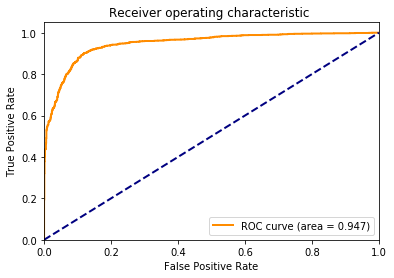

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score_get_value=[]
for item in y_score:
    y_score_get_value.append(item[0])
    
fpr, tpr, _ = roc_curve(y_test, y_score_get_value)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.savefig("roc.svg", format="svg")
plt.show()


